In [1]:
import os
import shutil
import random
import time
import json
import zipfile
import requests
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# 1. KONFIGURASI GLOBAL & HYPERPARAMETER

In [2]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Device Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Menggunakan Device: {DEVICE}")

# Paths
DATASET_URL = "https://data.mendeley.com/public-files/datasets/w9mr3vf56s/files/1339b6aa-0cb6-4b0d-9b0a-354b947610a2/file_downloaded"
BASE_DIR = "Chili_Leaf_Disease" # Folder ekstraksi
FINAL_DIR = "FinalDataset_PyTorch" # Folder hasil split

# Hyperparameters
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.0001
DROPOUT_RATE = 0.3
NUM_CLASSES = 6

🚀 Menggunakan Device: cuda


# 2. DOWNLOAD & DATASET PREPARATION


In [3]:
def setup_dataset():
    if not os.path.exists("datasets.zip"):
        print("⬇️ Sedang mendownload dataset...")
        response = requests.get(DATASET_URL, stream=True)
        with open("datasets.zip", "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

    if not os.path.exists(BASE_DIR):
        print("📂 Sedang mengekstrak dataset...")
        with zipfile.ZipFile("datasets.zip", 'r') as zip_ref:
            zip_ref.extractall(".")
        # Rename folder hasil ekstrak jika perlu (sesuaikan dengan nama folder asli di zip)
        # Asumsi nama folder hasil ekstrak adalah 'Chili Leaf Disease Original Dataset'
        if os.path.exists("Chili Leaf Disease Original Dataset"):
            os.rename("Chili Leaf Disease Original Dataset", BASE_DIR)

def create_split_folders():
    if os.path.exists(FINAL_DIR):
        print("✅ Folder dataset final sudah ada, melewati split.")
        return

    print("✂️ Membagi dataset menjadi Train/Val/Test...")
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(FINAL_DIR, split), exist_ok=True)

    for class_name in os.listdir(BASE_DIR):
        class_dir = os.path.join(BASE_DIR, class_name)
        if not os.path.isdir(class_dir): continue

        images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        random.shuffle(images)

        # Split 70:20:10 (kira-kira)
        train_imgs, test_imgs = train_test_split(images, test_size=0.1, random_state=RANDOM_SEED)
        train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.2/0.9, random_state=RANDOM_SEED)

        for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_dir = os.path.join(FINAL_DIR, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for src in split_imgs:
                shutil.copy(src, os.path.join(split_dir, os.path.basename(src)))

# Eksekusi setup data
setup_dataset()
create_split_folders()

⬇️ Sedang mendownload dataset...
📂 Sedang mengekstrak dataset...
✂️ Membagi dataset menjadi Train/Val/Test...


# 3. DATA TRANSFORM & LOADERS (AUGMENTATION)

In [4]:
# PyTorch menggunakan Normalisasi ImageNet (Mean & Std khusus)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomRotation(25),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(FINAL_DIR, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x == 'train'), num_workers=2)
               for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes
print(f"🏷️ Kelas: {class_names}")

🏷️ Kelas: ['Bacterial Spot', 'Cercospora Leaf Spot', 'Curl Virus', 'Healthy Leaf', 'Nutrition Deficiency', 'White spot']


# 4. DEFINISI ARSITEKTUR MODEL (PYTORCH)

In [5]:
# --- Custom Layers ---
class MCDropout(nn.Module):
    def __init__(self, p=0.3):
        super().__init__()
        self.p = p

    def forward(self, x):
        # force dropout to be active even during evaluation
        return F.dropout(x, p=self.p, training=True)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        # Channel pooling (mean & max) results in 2 channels
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Implementasi manual ChannelPooling (mean & max along dim 1)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(x_cat)
        return x * self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, planes, ratio=8, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

# --- Main Hybrid Model ---
class VGGEffAttnNet(nn.Module):
    def __init__(self, num_classes=6, dropout_rate=0.3):
        super().__init__()

        # 1. Branch VGG16
        vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        # Freeze layers except last 4 convolutional layers
        features = list(vgg.features.children())
        for layer in features[:-4]:
            for param in layer.parameters(): param.requires_grad = False
        self.vgg_features = vgg.features
        self.vgg_avgpool = vgg.avgpool # Output: 512x7x7 -> flatten -> 25088
        self.vgg_fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),
            nn.ReLU(),
            MCDropout(dropout_rate)
        )

        # 2. Branch EfficientNet B0
        eff = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        # Freeze layers logic (simplified for PyTorch: unfreeze last block)
        for param in eff.features.parameters(): param.requires_grad = False
        for param in eff.features[-1].parameters(): param.requires_grad = True

        self.eff_features = eff.features # Output: 1280x7x7

        # Attention & Pooling for EfficientNet Branch
        self.eff_cbam = CBAM(planes=1280)
        self.eff_gap = nn.AdaptiveAvgPool2d(1)
        self.eff_fc = MCDropout(dropout_rate) # Applied after flattening

        # 3. Fusion
        # Input fusion: 256 (VGG) + 1280 (EffNet) = 1536
        self.fusion_fc = nn.Sequential(
            nn.Linear(256 + 1280, 256),
            nn.ReLU(),
            MCDropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # --- VGG Branch ---
        v_x = self.vgg_features(x)
        v_x = self.vgg_avgpool(v_x)
        v_x = torch.flatten(v_x, 1)
        v_out = self.vgg_fc(v_x) # Shape: (Batch, 256)

        # --- EfficientNet Branch ---
        e_x = self.eff_features(x) # Shape: (Batch, 1280, 7, 7)

        # Apply CBAM
        e_att = self.eff_cbam(e_x)

        # Skip Connection (Original + Attention)
        e_refined = e_x + e_att

        # GAP
        e_refined = self.eff_gap(e_refined)
        e_refined = torch.flatten(e_refined, 1) # Shape: (Batch, 1280)
        e_out = self.eff_fc(e_refined)

        # --- Fusion ---
        concat = torch.cat((v_out, e_out), dim=1)
        output = self.fusion_fc(concat)

        return output

# 5. TRAINING LOOP


In [6]:
def train_model(model, criterion, optimizer, num_epochs=25, patience=5):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    # History storage
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Early stopping vars
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} phase"):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            # Deep copy the model & Early Stopping check
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    torch.save(model.state_dict(), 'best_model_pytorch.pth')
                    print("💾 Model terbaik disimpan!")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"🛑 Early stopping triggered setelah {patience} epochs tanpa perbaikan.")
            break

    time_elapsed = time.time() - since
    print(f'\nTraining selesai dalam {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:4f}')

    # Load best weights
    model.load_state_dict(best_model_wts)
    return model, history

# 6. EKSEKUSI TRAINING



🛠️ Membangun Model PyTorch...
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 145MB/s] 


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 168MB/s]



Epoch 1/50
----------


train phase: 100%|██████████| 81/81 [00:20<00:00,  3.86it/s]


Train Loss: 1.0234 Acc: 0.6502


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]


Val Loss: 0.3908 Acc: 0.8740
💾 Model terbaik disimpan!

Epoch 2/50
----------


train phase: 100%|██████████| 81/81 [00:20<00:00,  3.97it/s]


Train Loss: 0.3025 Acc: 0.9058


val phase: 100%|██████████| 24/24 [00:06<00:00,  3.70it/s]


Val Loss: 0.1845 Acc: 0.9357
💾 Model terbaik disimpan!

Epoch 3/50
----------


train phase: 100%|██████████| 81/81 [00:19<00:00,  4.26it/s]


Train Loss: 0.1636 Acc: 0.9452


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.15it/s]


Val Loss: 0.1493 Acc: 0.9544
💾 Model terbaik disimpan!

Epoch 4/50
----------


train phase: 100%|██████████| 81/81 [00:19<00:00,  4.18it/s]


Train Loss: 0.1219 Acc: 0.9645


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]


Val Loss: 0.1026 Acc: 0.9705
💾 Model terbaik disimpan!

Epoch 5/50
----------


train phase: 100%|██████████| 81/81 [00:21<00:00,  3.69it/s]


Train Loss: 0.0794 Acc: 0.9730


val phase: 100%|██████████| 24/24 [00:04<00:00,  4.96it/s]


Val Loss: 0.0807 Acc: 0.9571

Epoch 6/50
----------


train phase: 100%|██████████| 81/81 [00:20<00:00,  4.02it/s]


Train Loss: 0.0617 Acc: 0.9807


val phase: 100%|██████████| 24/24 [00:04<00:00,  4.97it/s]


Val Loss: 0.0629 Acc: 0.9705

Epoch 7/50
----------


train phase: 100%|██████████| 81/81 [00:20<00:00,  4.00it/s]


Train Loss: 0.0752 Acc: 0.9753


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.44it/s]


Val Loss: 0.0435 Acc: 0.9812
💾 Model terbaik disimpan!

Epoch 8/50
----------


train phase: 100%|██████████| 81/81 [00:21<00:00,  3.77it/s]


Train Loss: 0.0549 Acc: 0.9830


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.51it/s]


Val Loss: 0.0404 Acc: 0.9812

Epoch 9/50
----------


train phase: 100%|██████████| 81/81 [00:21<00:00,  3.82it/s]


Train Loss: 0.0344 Acc: 0.9907


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.64it/s]


Val Loss: 0.0480 Acc: 0.9812

Epoch 10/50
----------


train phase: 100%|██████████| 81/81 [00:21<00:00,  3.85it/s]


Train Loss: 0.0354 Acc: 0.9861


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.75it/s]


Val Loss: 0.0587 Acc: 0.9786

Epoch 11/50
----------


train phase: 100%|██████████| 81/81 [00:20<00:00,  3.89it/s]


Train Loss: 0.0327 Acc: 0.9900


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.78it/s]


Val Loss: 0.0564 Acc: 0.9812

Epoch 12/50
----------


train phase: 100%|██████████| 81/81 [00:20<00:00,  3.88it/s]


Train Loss: 0.0369 Acc: 0.9915


val phase: 100%|██████████| 24/24 [00:04<00:00,  4.83it/s]


Val Loss: 0.0315 Acc: 0.9920
💾 Model terbaik disimpan!

Epoch 13/50
----------


train phase: 100%|██████████| 81/81 [00:20<00:00,  3.94it/s]


Train Loss: 0.0263 Acc: 0.9923


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.79it/s]


Val Loss: 0.0202 Acc: 0.9920

Epoch 14/50
----------


train phase: 100%|██████████| 81/81 [00:20<00:00,  3.92it/s]


Train Loss: 0.0419 Acc: 0.9846


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.76it/s]


Val Loss: 0.0343 Acc: 0.9920

Epoch 15/50
----------


train phase: 100%|██████████| 81/81 [00:20<00:00,  3.92it/s]


Train Loss: 0.0236 Acc: 0.9900


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.68it/s]


Val Loss: 0.0292 Acc: 0.9920

Epoch 16/50
----------


train phase: 100%|██████████| 81/81 [00:20<00:00,  3.88it/s]


Train Loss: 0.0205 Acc: 0.9946


val phase: 100%|██████████| 24/24 [00:04<00:00,  4.84it/s]


Val Loss: 0.0234 Acc: 0.9920

Epoch 17/50
----------


train phase: 100%|██████████| 81/81 [00:20<00:00,  3.88it/s]


Train Loss: 0.0178 Acc: 0.9946


val phase: 100%|██████████| 24/24 [00:04<00:00,  4.81it/s]


Val Loss: 0.0127 Acc: 0.9973
💾 Model terbaik disimpan!

Epoch 18/50
----------


train phase: 100%|██████████| 81/81 [00:21<00:00,  3.83it/s]


Train Loss: 0.0344 Acc: 0.9915


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.76it/s]


Val Loss: 0.0258 Acc: 0.9946

Epoch 19/50
----------


train phase: 100%|██████████| 81/81 [00:21<00:00,  3.86it/s]


Train Loss: 0.0235 Acc: 0.9915


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.69it/s]


Val Loss: 0.0269 Acc: 0.9893

Epoch 20/50
----------


train phase: 100%|██████████| 81/81 [00:21<00:00,  3.82it/s]


Train Loss: 0.0163 Acc: 0.9954


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]


Val Loss: 0.0353 Acc: 0.9786

Epoch 21/50
----------


train phase: 100%|██████████| 81/81 [00:21<00:00,  3.77it/s]


Train Loss: 0.0212 Acc: 0.9938


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.72it/s]


Val Loss: 0.0151 Acc: 0.9920

Epoch 22/50
----------


train phase: 100%|██████████| 81/81 [00:20<00:00,  3.92it/s]


Train Loss: 0.0249 Acc: 0.9900


val phase: 100%|██████████| 24/24 [00:05<00:00,  4.73it/s]


Val Loss: 0.0442 Acc: 0.9866
🛑 Early stopping triggered setelah 5 epochs tanpa perbaikan.

Training selesai dalam 9m 34s
Best Val Acc: 0.997319


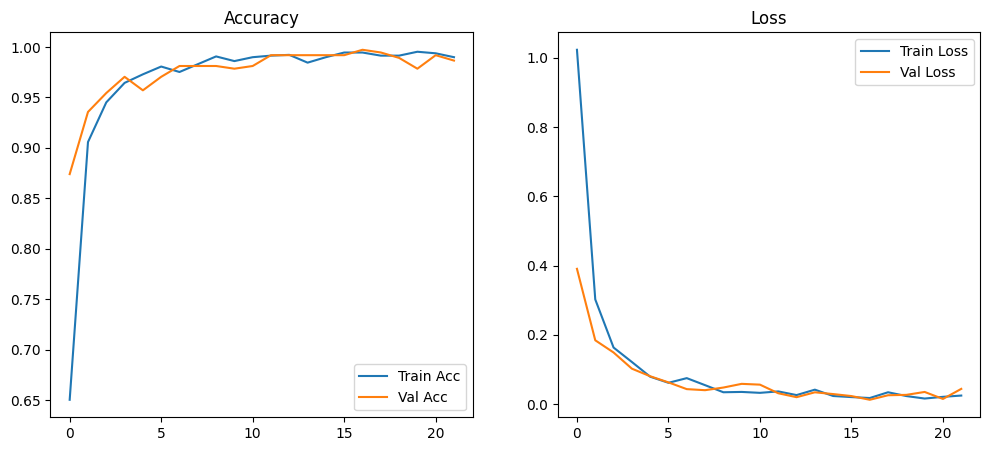

In [7]:
print("\n🛠️ Membangun Model PyTorch...")
model = VGGEffAttnNet(num_classes=NUM_CLASSES, dropout_rate=DROPOUT_RATE)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

model, history = train_model(model, criterion, optimizer, num_epochs=EPOCHS, patience=5)

# Plot History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


# 7. EVALUATION & TESTING


📊 Memulai Evaluasi Test Set...


Testing: 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]



HASIL EVALUASI TEST SET
                      precision    recall  f1-score   support

      Bacterial Spot     1.0000    1.0000    1.0000        16
Cercospora Leaf Spot     1.0000    0.9444    0.9714        18
          Curl Virus     1.0000    1.0000    1.0000        43
        Healthy Leaf     1.0000    1.0000    1.0000        46
Nutrition Deficiency     0.9783    1.0000    0.9890        45
          White spot     1.0000    1.0000    1.0000        20

            accuracy                         0.9947       188
           macro avg     0.9964    0.9907    0.9934       188
        weighted avg     0.9948    0.9947    0.9946       188

✅ Accuracy: 99.4681%
⏱️ Rata-rata Inference Time: 2.87 ms/image


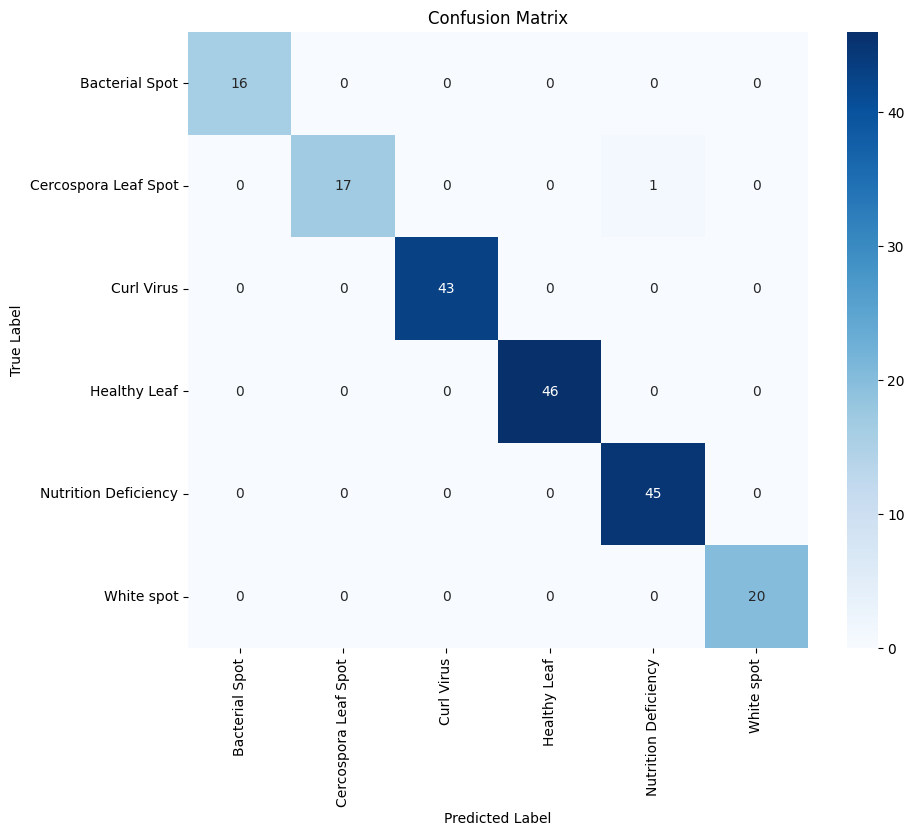

📝 Class names disimpan ke class_names.json


In [8]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    inference_times = []

    print("\n📊 Memulai Evaluasi Test Set...")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            start = time.time()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            end = time.time()

            inference_times.append((end - start) / inputs.size(0)) # Time per batch / batch_size

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Metrics
    print("\n" + "="*40)
    print("HASIL EVALUASI TEST SET")
    print("="*40)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    avg_infer_ms = np.mean(inference_times) * 1000

    print(f"✅ Accuracy: {acc:.4%}")
    print(f"⏱️ Rata-rata Inference Time: {avg_infer_ms:.2f} ms/image")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Jalankan Evaluasi
evaluate_model(model, dataloaders['test'])

# Simpan juga class names untuk deployment
with open("class_names.json", "w") as f:
    json.dump(class_names, f)
print("📝 Class names disimpan ke class_names.json")

# # 8. VISUALISASI HASIL PREDIKSI PER KELAS


🖼️ Memulai Visualisasi Sampel Prediksi per Kelas...


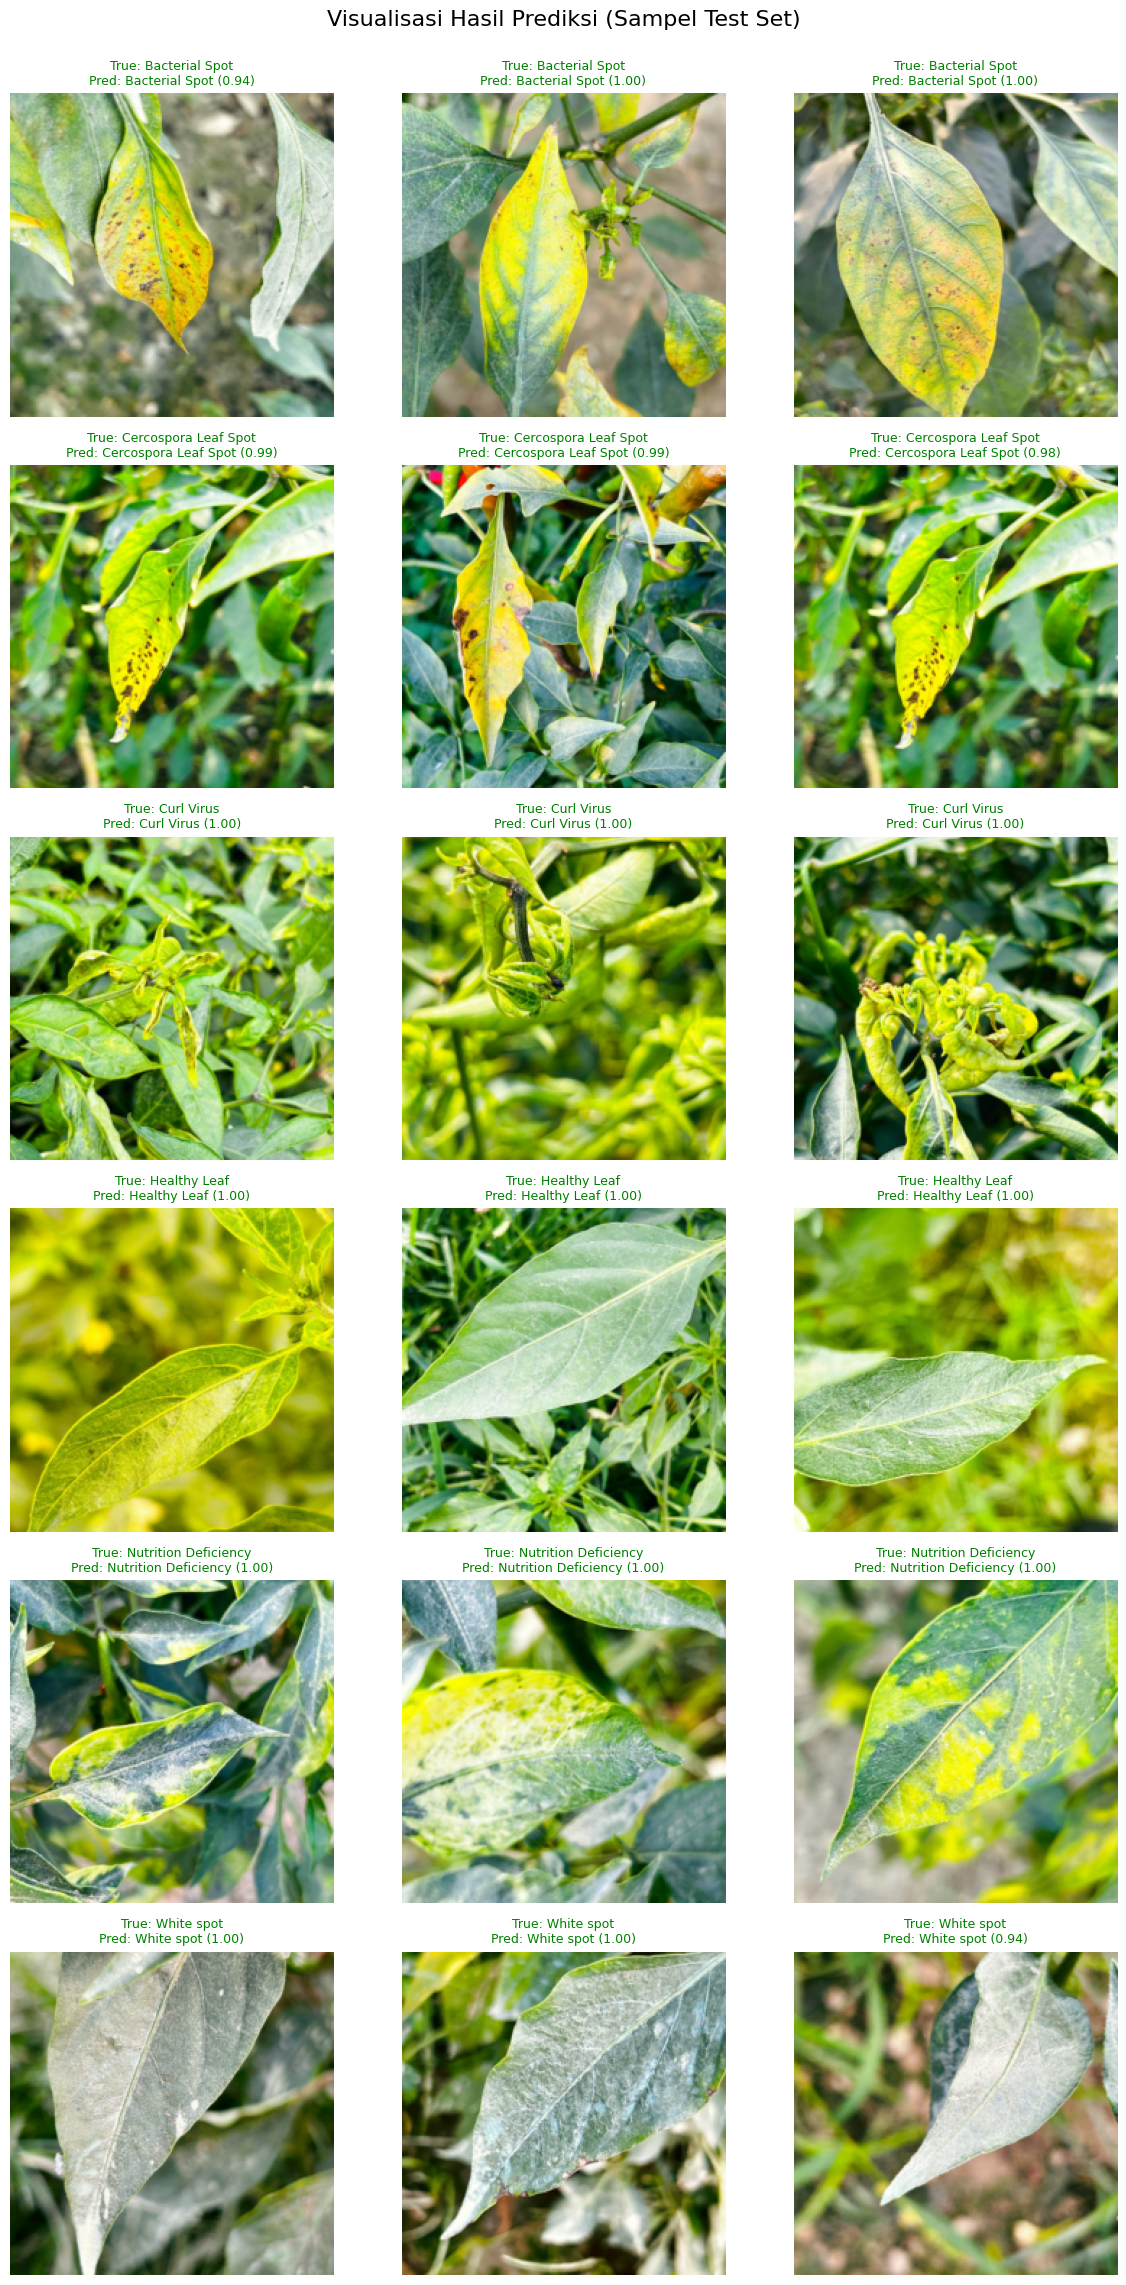

In [9]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def unnormalize_tensor(tensor):
    """Mengembalikan tensor (citra) dari normalisasi ImageNet ke skala 0-1."""
    # Menghapus batch dimension (C, H, W)
    img = tensor.cpu().numpy().transpose((1, 2, 0))
    # Un-normalize
    img = img * IMAGENET_STD + IMAGENET_MEAN
    # Clip ke rentang 0-1
    img = np.clip(img, 0, 1)
    return img

def visualize_class_predictions(model, dataset, class_names, num_samples=3):
    """Visualisasi beberapa sampel gambar dari setiap kelas di test set."""
    print("\n🖼️ Memulai Visualisasi Sampel Prediksi per Kelas...")
    model.eval()

    # Mendapatkan semua index gambar berdasarkan label
    targets = np.array(dataset.targets)

    # Siapkan figure untuk plot
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(4 * num_samples, 4 * num_classes))
    fig.suptitle('Visualisasi Hasil Prediksi (Sampel Test Set)', fontsize=16)

    with torch.no_grad():
        for i, class_name in enumerate(class_names):
            # Cari indeks gambar untuk kelas saat ini
            class_indices = np.where(targets == i)[0]

            # Ambil sampel acak
            if len(class_indices) > num_samples:
                sample_indices = random.sample(list(class_indices), num_samples)
            else:
                sample_indices = class_indices # Jika sampel kurang dari num_samples

            for j, data_idx in enumerate(sample_indices):
                # Ambil data: image, label (index)
                img_tensor, true_label_idx = dataset[data_idx]

                # Tambahkan batch dimension (1, C, H, W)
                input_tensor = img_tensor.unsqueeze(0).to(DEVICE)

                # Prediksi
                output = model(input_tensor)
                probs = F.softmax(output, dim=1).squeeze().cpu().numpy()
                pred_label_idx = np.argmax(probs)
                confidence = probs[pred_label_idx]

                # Visualisasi
                img = unnormalize_tensor(img_tensor)
                ax = axes[i, j] if num_classes > 1 else axes[j]

                # Tentukan warna judul
                color = 'green' if pred_label_idx == true_label_idx else 'red'

                title = f"True: {class_names[true_label_idx]}\nPred: {class_names[pred_label_idx]} ({confidence:.2f})"

                ax.imshow(img)
                ax.set_title(title, color=color, fontsize=9)
                ax.axis('off')

            # Jika jumlah sampel yang diambil kurang dari num_samples, kosongkan sisa kolom
            if len(class_indices) < num_samples and num_classes > 1:
                for k in range(len(class_indices), num_samples):
                    axes[i, k].axis('off')
            elif len(class_indices) < num_samples and num_classes == 1:
                for k in range(len(class_indices), num_samples):
                    axes[k].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

# Jalankan Visualisasi
# Menggunakan image_datasets['test'] karena kita butuh index data untuk sampling
visualize_class_predictions(model, image_datasets['test'], class_names, num_samples=3)

In [10]:
!pip install torchviz

In [12]:
from torchviz import make_dot

# Pindahkan model ke CPU
model_cpu = model.to("cpu")
model_cpu.eval()

# Buat input di CPU
x = torch.randn(1, 3, 224, 224)

# Forward
y = model_cpu(x)

# Buat diagram
dot = make_dot(y, params=dict(model_cpu.named_parameters()))
dot.format = "png"
dot.render("model_torchviz")

print("Saved as model_torchviz.png")


Saved as model_torchviz.png
